In [34]:
import numpy as np
import pandas as pd

df = pd.read_csv("data/voting_VA.csv")

print(df.head())
print(df.isnull().sum())

   Unnamed: 0  year     state state_po county_name  county_fips        office  \
0       11161  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
1       11162  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
2       11163  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
3       11164  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
4       11165  2000  VIRGINIA       VA   ALBEMARLE        51003  US PRESIDENT   

        candidate       party  candidatevotes  totalvotes   version   mode  
0         AL GORE    DEMOCRAT            5092       11925  20220315  TOTAL  
1  GEORGE W. BUSH  REPUBLICAN            6352       11925  20220315  TOTAL  
2     RALPH NADER       GREEN             220       11925  20220315  TOTAL  
3           OTHER       OTHER             261       11925  20220315  TOTAL  
4         AL GORE    DEMOCRAT           16255       36846  20220315  TOTAL  
Unnamed: 0        0
year              0
state      

In [35]:
# Remove the 'Unnamed: 0' column
df.drop('Unnamed: 0', axis=1, inplace=True)

# Check unique values for certain columns to ensure consistency
print(df['state'].unique())  # Should only contain "VIRGINIA"
print(df['state_po'].unique())  # Should only contain "VA"
print(df['office'].unique())  # Should only contain "US PRESIDENT"
print(df['mode'].unique())  # Check if any action is needed

['VIRGINIA']
['VA']
['US PRESIDENT']
['TOTAL' 'ABSENTEE' 'ELECTION DAY' 'PROVISIONAL']


In [36]:
df['mode'].head()

0    TOTAL
1    TOTAL
2    TOTAL
3    TOTAL
4    TOTAL
Name: mode, dtype: object

In [37]:
# If we're interested in overall voting results without differentiating between the modes:
# df_total = df[df['mode'] == 'TOTAL']
# df_total.to_csv("data/clean_total_voting_VA.csv", index=False) 

# Otherwise, we can keep all of the modes of voting and use them as features
# in our models
df['mode'] = df['mode'].astype('category')
df['mode'].head()

0    TOTAL
1    TOTAL
2    TOTAL
3    TOTAL
4    TOTAL
Name: mode, dtype: category
Categories (4, object): ['ABSENTEE', 'ELECTION DAY', 'PROVISIONAL', 'TOTAL']

In [38]:
# Provides a dataframe where the modes aggregates all individual records across different voting modes 
# into a single record per candidate per county per election year. 

df_aggregated = df.groupby(['year', 'county_name', 'county_fips', 'candidate', 'party']).agg({
    'candidatevotes': 'sum',
    'totalvotes': 'max'  # Assuming totalvotes is the same across all modes, otherwise sum might be needed
}).reset_index()

df_aggregated.head()

,year,county_name,county_fips,candidate,party,candidatevotes,totalvotes
0,2000,ACCOMACK,51001,AL GORE,DEMOCRAT,5092,11925
1,2000,ACCOMACK,51001,GEORGE W. BUSH,REPUBLICAN,6352,11925
2,2000,ACCOMACK,51001,OTHER,OTHER,261,11925
3,2000,ACCOMACK,51001,RALPH NADER,GREEN,220,11925
4,2000,ALBEMARLE,51003,AL GORE,DEMOCRAT,16255,36846


In [39]:
import pandas as pd
#removing candidates column (unimportant)
df_real = df_aggregated.drop('candidate', axis=1)
#removing third parties (also unimportant)
df_real = df_real[~df_real['party'].isin(['OTHER', 'GREEN'])]
#finding net total votes
df_real['net_total'] = df_real.groupby(['year', 'county_name', 'county_fips', 'totalvotes'])['candidatevotes'].transform(lambda x: x.iloc[1] - x.iloc[0])

# merging columns
df_real = df_real.groupby(['year', 'county_name', 'county_fips', 'totalvotes', 'net_total']).agg({'party': ', '.join}).reset_index()
df_real['winner'] = df_real['net_total'].apply(lambda x: 'REPUBLICAN' if x > 0 else 'DEMOCRAT')
#dropping some more columns
df_real = df_real.drop(['party', 'totalvotes'], axis=1)
df_final = df_real[['year', 'county_name', 'county_fips','net_total', 'winner']]
df_final.head()

,year,county_name,county_fips,net_total,winner
0,2000,ACCOMACK,51001,1260,REPUBLICAN
1,2000,ALBEMARLE,51003,2036,REPUBLICAN
2,2000,ALEXANDRIA,51510,-14590,DEMOCRAT
3,2000,ALLEGHANY,51005,594,REPUBLICAN
4,2000,AMELIA,51007,1193,REPUBLICAN


In [40]:
df_melt = pd.read_csv("data/df_melt.csv")

year_mapping = {
    2000: 2000,
    2004: 2000,
    2008: 125,
    2012: 125,
    2016: 195,
    2020: 195
}
df_final['melt_year'] = df_final['year'].map(year_mapping)

# Convert columns to the same data type before merging
df_final['melt_year'] = df_final['melt_year'].astype(str)
df_final['county_fips'] = df_final['county_fips'].astype(str)
df_melt['YEAR'] = df_melt['YEAR'].astype(str)
df_melt['FIPS'] = df_melt['FIPS'].astype(str)

merged_df = pd.merge(df_final, df_melt, left_on=['melt_year', 'county_fips'], right_on=['YEAR', 'FIPS'])

columns_to_drop = ['YEAR', 'FIPS', 'melt_year']
df_updated = merged_df.drop(columns=columns_to_drop)

print(df_updated.head())

   year county_name county_fips  net_total      winner     AV0AA     B78AA  \
0  2000    ACCOMACK       51001       1260  REPUBLICAN   38305.0   38305.0   
1  2004    ACCOMACK       51001      -2208    DEMOCRAT   38305.0   38305.0   
2  2000   ALBEMARLE       51003       2036  REPUBLICAN   79236.0   79236.0   
3  2004   ALBEMARLE       51003        899  REPUBLICAN   79236.0   79236.0   
4  2000  ALEXANDRIA       51510     -14590    DEMOCRAT  128283.0  128283.0   

     AV1AA    AV1AB    AT5AA  ...   A88AD    A88AE    AB2AA    BD5AA  \
0  18590.0  19715.0  36680.0  ...  3781.0   3195.0  34821.0  16309.0   
1  18590.0  19715.0  36680.0  ...  3781.0   3195.0  34821.0  16309.0   
2  38002.0  41234.0  73483.0  ...  5153.0  13401.0  63407.0  28852.0   
3  38002.0  41234.0  73483.0  ...  5153.0  13401.0  63407.0  28852.0   
4  61974.0  66309.0  95683.0  ...  6275.0  17685.0  67023.0  37645.0   

      AX6AA    CL6AA    AX7AA     AX7AB  BV8AA   BV8AB  
0   37715.0   6788.0   6788.0   30927.0  

In [41]:
df_updated = df_updated.drop(columns=['winner'])
df_updated = pd.get_dummies(df_updated, columns=['county_name'])
df_updated = df_updated.astype(float)
df_2020 = df_updated[df_updated['year'] == 2020]
df_total = df_updated[df_updated['year'] != 2020]
df_2020.reset_index(drop=True, inplace=True)
df_total.reset_index(drop=True, inplace=True)

In [42]:
# Neural network time!
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

y = df_total['net_total'].astype(float)
X = df_total.drop('net_total', axis=1).astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

net = Sequential()
#Having 3 layers results in Loss: 218362592.0, Mean Absolute Error (MAE): 6693.912109375, Mean Squared Error (MSE): 218362592.0
net.add(Dense(units=82, activation='relu', input_dim=X_train.shape[1]))
#net.add(Dense(units=32, activation='relu'))
net.add(Dense(units=1, activation='linear'))

net.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

net.fit(X_train, y_train, epochs=25, verbose=1, batch_size=50)

# use it to predict testing data
evaluation = net.evaluate(X_test, y_test)

# Extract the evaluation metrics
loss = evaluation[0]
mae = evaluation[1]
mse = evaluation[2]
print("Evaluation metrics:")
print(f"Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

Epoch 1/25
11/11 [==============================] - 0s 2ms/step - loss: 183180496.0000 - mae: 5454.5244 - mse: 183180496.0000
Epoch 2/25
11/11 [==============================] - 0s 1ms/step - loss: 183180480.0000 - mae: 5454.5244 - mse: 183180480.0000
Epoch 3/25
11/11 [==============================] - 0s 1ms/step - loss: 183180480.0000 - mae: 5454.5244 - mse: 183180480.0000
Epoch 4/25
11/11 [==============================] - 0s 1ms/step - loss: 183180496.0000 - mae: 5454.5244 - mse: 183180496.0000
Epoch 5/25
11/11 [==============================] - 0s 1ms/step - loss: 183180480.0000 - mae: 5454.5244 - mse: 183180480.0000
Epoch 6/25
11/11 [==============================] - 0s 1ms/step - loss: 183180464.0000 - mae: 5454.5249 - mse: 183180464.0000
Epoch 7/25
11/11 [==============================] - 0s 1ms/step - loss: 183180464.0000 - mae: 5454.5249 - mse: 183180464.0000
Epoch 8/25
11/11 [==============================] - 0s 1ms/step - loss: 183180480.0000 - mae: 5454.5244 - mse: 1831804

In [43]:
# Then use it to predict data from 2020 election since it's closest to current election
predictions_2020 = net.predict(df_2020.drop('net_total', axis=1))

# Sum all the predictions
total_prediction = predictions_2020.sum()

# Check if the total prediction is positive, negative, or zero
if total_prediction > 0:
    print("R wins by "+ str(total_prediction))
elif total_prediction < 0:
    print("D wins by "+ str(total_prediction))
else:
    print("Cannot make a prediction.")

5/5 [==============================] - 0s 2ms/step
D wins by -3.4829764


In [44]:
#Then evaluate the actual accuracy of the prediction. 
evaluation_2020 = net.evaluate(df_2020.drop('net_total', axis=1), df_2020['net_total'])

# Extract the evaluation metrics
loss_2020 = evaluation_2020[0]
mae_2020 = evaluation_2020[1]
mse_2020 = evaluation_2020[2]
print("Evaluation metrics on 2020 data:")
print(f"Loss: {loss_2020}")
print(f"Mean Absolute Error (MAE): {mae_2020}")
print(f"Mean Squared Error (MSE): {mse_2020}")


5/5 [==============================] - 0s 2ms/step - loss: 646246016.0000 - mae: 14268.1621 - mse: 646246016.0000
Evaluation metrics on 2020 data:
Loss: 646246016.0
Mean Absolute Error (MAE): 14268.162109375
Mean Squared Error (MSE): 646246016.0


In [45]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
rf = model.fit(X_train,y_train)

# Make predictions:
y_hat_rf = rf.predict(X_test) # Model predictions

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [46]:
#Now for the linear regression:

In [49]:
import pandas as pd
df_lr = df_total.copy()
print(df_lr.isna().sum())

year                           0
county_fips                    0
net_total                      0
AV0AA                          1
B78AA                          1
                              ..
county_name_WINCHESTER         0
county_name_WINCHESTER CITY    0
county_name_WISE               0
county_name_WYTHE              0
county_name_YORK               0
Length: 330, dtype: int64


In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

print(df_lr.head())

     year  county_fips  net_total     AV0AA     B78AA    AV1AA    AV1AB  \
0  2000.0      51001.0     1260.0   38305.0   38305.0  18590.0  19715.0   
1  2004.0      51001.0    -2208.0   38305.0   38305.0  18590.0  19715.0   
2  2000.0      51003.0     2036.0   79236.0   79236.0  38002.0  41234.0   
3  2004.0      51003.0      899.0   79236.0   79236.0  38002.0  41234.0   
4  2000.0      51510.0   -14590.0  128283.0  128283.0  61974.0  66309.0   

     AT5AA    AT5AB    AL8AA  ...  county_name_WAYNESBORO  \
0  36680.0   1625.0  22535.0  ...                     0.0   
1  36680.0   1625.0  22535.0  ...                     0.0   
2  73483.0   5753.0  39195.0  ...                     0.0   
3  73483.0   5753.0  39195.0  ...                     0.0   
4  95683.0  32600.0  27840.0  ...                     0.0   

   county_name_WAYNESBORO CITY  county_name_WESTMORELAND  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2 

In [51]:
for column in df_lr.columns:
    df_lr[f'missing_indicator_{column}'] = df_lr[column].isna().astype(int)
df_lr.fillna(0, inplace=True)

/tmp/ipykernel_765707/1622902478.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lr[f'missing_indicator_{column}'] = df_lr[column].isna().astype(int)
/tmp/ipykernel_765707/1622902478.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lr[f'missing_indicator_{column}'] = df_lr[column].isna().astype(int)
/tmp/ipykernel_765707/1622902478.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

In [52]:
# Assuming df_total is prepared with necessary preprocessing
y = df_lr['net_total'].astype(float)
X = df_lr.drop('net_total', axis=1).astype(float)

In [53]:
print(X.isna().sum())
print(y.isna().sum())

year                                             0
county_fips                                      0
AV0AA                                            0
B78AA                                            0
AV1AA                                            0
                                                ..
missing_indicator_county_name_WINCHESTER         0
missing_indicator_county_name_WINCHESTER CITY    0
missing_indicator_county_name_WISE               0
missing_indicator_county_name_WYTHE              0
missing_indicator_county_name_YORK               0
Length: 659, dtype: int64
0


In [54]:
# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# the lr model
model = LinearRegression()

In [56]:
# fitting
model.fit(X_train, y_train)

LinearRegression()

In [57]:
y_pred = model.predict(X_test)

In [58]:
# evaluating model accuracy
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 4561411588.389202
R^2 Score: -48.08582333834583


In [59]:
#Visualization

/tmp/ipykernel_765707/650600978.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


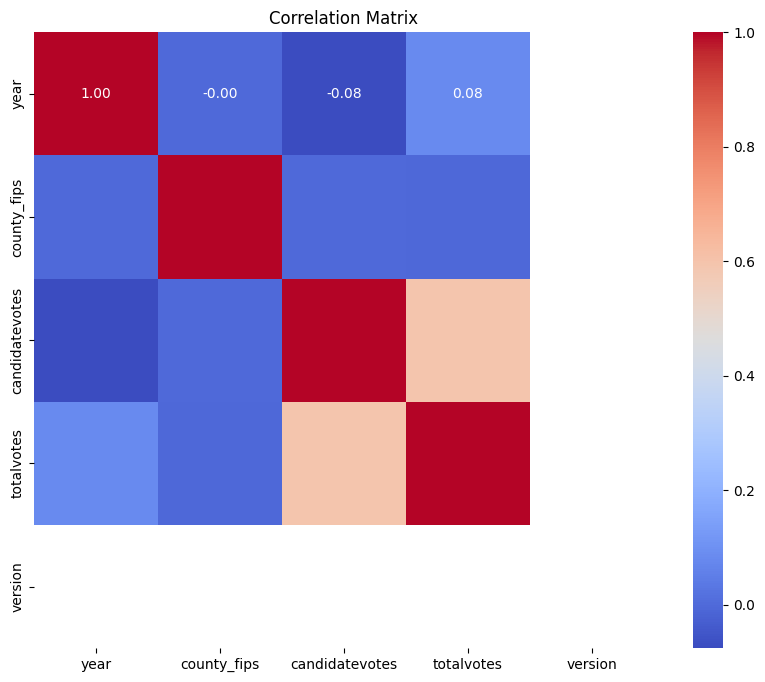

In [60]:
#correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()